In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy
import os
import json
from tqdm.auto import tqdm
import copy

In [2]:
project = sg.get_project()
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42
fri_vec = b_vec * gamma(1+1/c)

### Expected val

In [3]:
A = 1
# jobs = project.find_jobs({'doc.simulated': True, 'A': A})
jobs = np.ones(2000) if A==1 else np.ones(1000)
all_fri = np.tile(fri_vec, len(jobs))
fn = "aggregate_data/all_r_{}.npy".format(A)
if not os.path.isfile(fn):
    all_r = np.array([]) 
    for job_i, job in enumerate(jobs):
        with job.data as data:
            frac_change_vec = []
            for b in b_vec:
                frac_change_vec.append(float(data['fractional_change/{}'.format(b)]))
        all_r = np.append(all_r, frac_change_vec)
    with open(fn, 'wb') as handle:
        np.save(handle, all_r) 
else:
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)

In [4]:
# cap = 400
# all_fri = all_fri[:(b_vec.shape[0]*cap)]
# all_r = all_r[:(b_vec.shape[0]*cap)]

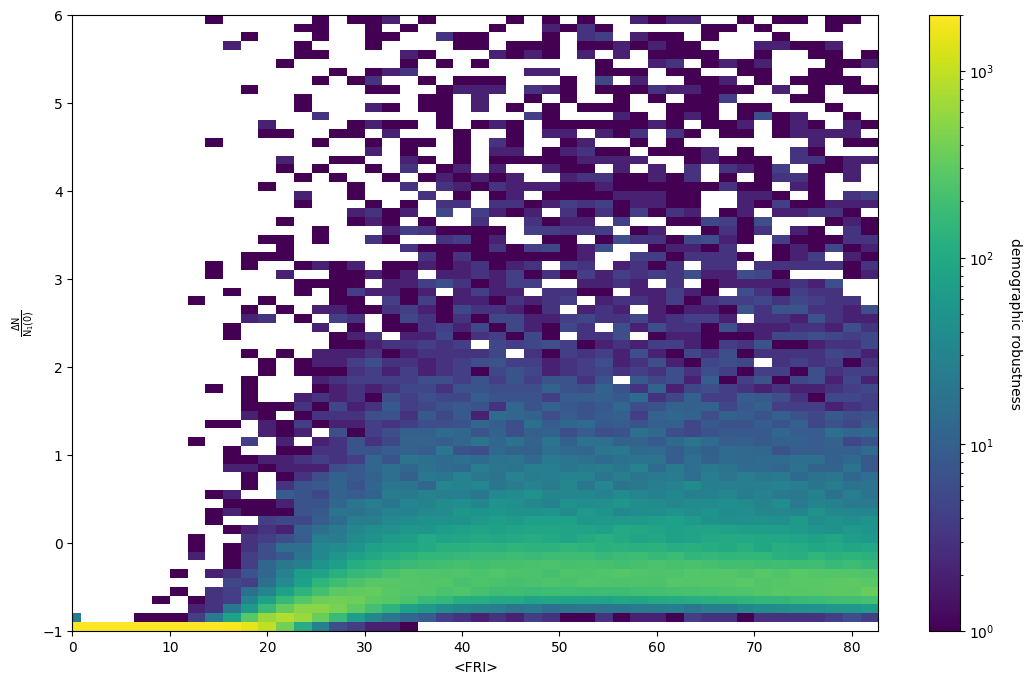

In [5]:
r_bw=0.1
r_edges = np.arange(-1, 6+r_bw, r_bw)
# r_edges = np.arange(-1, max(all_r)+r_bw, r_bw)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
fig, ax = plt.subplots(figsize=(13,8))
# hist = ax.hist2d(all_fri, all_r, bins=[fri_edges, r_edges], 
#                  norm=matplotlib.colors.Normalize(vmin=0, vmax=len(jobs)))
hist = ax.hist2d(all_fri, all_r, bins=[fri_edges, r_edges], 
                 norm=matplotlib.colors.LogNorm(vmax=int(len(all_r)/len(b_vec))))
cbar = ax.figure.colorbar(hist[-1], ax=ax, location="right")
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ax.set_xlabel('<FRI>')
ax.set_ylabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
if not os.path.isdir('figs/A_{}'.format(A)):
    os.makedirs('figs/A_{}'.format(A))
# fig.savefig('figs/A_{}/sensitvity.png'.format(A), bbox_inches='tight')

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_61591/3665058096.py:29: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


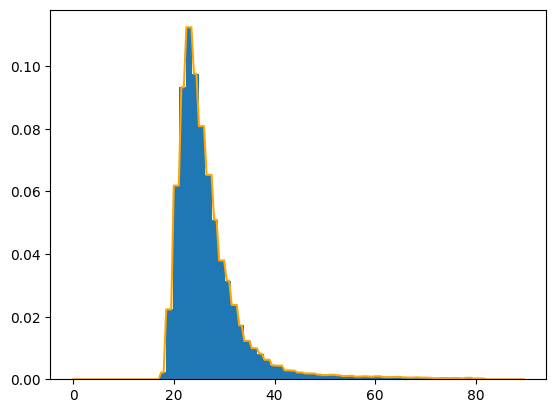

In [6]:
# Read in fixed fire map 
# fdmfn = 'FDE_current.txt'
# fdmfn = 'current_SW.asc'
fdmfn = 'FDE_current_allregions.asc'
if fdmfn[-3:] == 'txt':
    fdm = np.loadtxt(fdmfn)
else:
    # Assume these are uncropped .asc maps
    # fdm = np.loadtxt(fdmfn, skiprows=6)
    ul_coord = [1500, 2800]
    lr_coord = [2723, 3905]
    usecols = np.arange(ul_coord[0],lr_coord[0])
    fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                             max_rows=lr_coord[1], usecols=usecols)
# Read in patchmap 
patchmapfn = 'frame0_patchmap.ASC'
# patchmapfn = 'frame1_patchmap_cnrm85.ASC'
patchmap = np.loadtxt(patchmapfn, skiprows=6)
def adjustmaps(maps):
    dim_len = []
    for dim in range(2):
        dim_len.append(min([m.shape[dim] for m in maps]))
    for mi, m in enumerate(maps):
        maps[mi] = m[0:dim_len[0], 0:dim_len[1]]
    return maps
patchmap, fdm = adjustmaps([patchmap, fdm])
delta_t = 30
c = 1.42
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
fri_raster = b_raster * gamma(1+1/c)
fri_sub = fri_raster[(patchmap > 0) & (fdm > 0)] # Why are there any zeros in FDM at all?
fri_flat = fri_sub.flatten()
fri_hist = plt.hist(fri_flat[fri_flat < max(fri_vec)], bins=50, density=True);
P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))
x = np.arange(0,90,0.5)
plt.plot(x, P_fri_x0.pdf(x), color='orange')
# plt.hist(1 / fri_flat[fri_flat < max(fri_vec)], bins=50);
# plt.axvline(1/66, c='k')

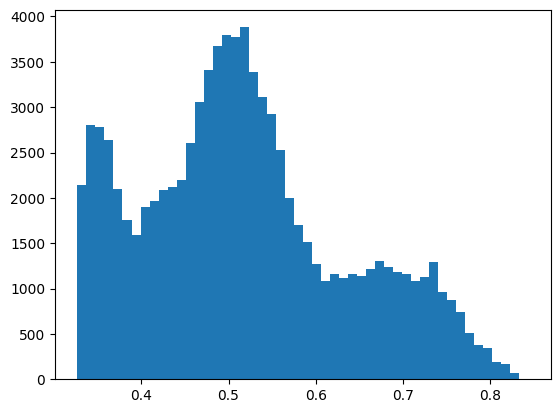

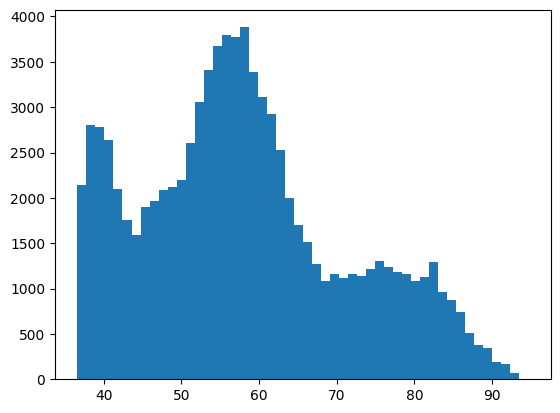

In [7]:
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
# plt.imshow(sdm)
# plt.show()
sdm_flat = sdm.flatten()[sdm.flatten() != 0]
plt.hist(sdm_flat, bins=50)
plt.show()

A_cell = (270**2)/10000
A_o = 0.1
h_o = 0.65 #just a guess
# Histogram an estimate for the effective area relative to 'A=1' with adjustments for the on-site A and H
plt.hist((sdm_flat*A_cell)/(h_o*A_o), bins=50);

In [9]:
dfri = 0.01
dr = 0.01
r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
r_expect = 0
for fri_i in range(len(hist[0])):
    P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
    r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
    fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
    # This is a bad approximation, where I assume P_r_fri does not change within this fri bin
    # using for now because I sampled uniformly in b for each demo sample
    # rerun data with random sampling in b?
    P_dfri = np.trapz(y=P_fri_x0.pdf(fri_vals), x=fri_vals)
    r_expect += r_expect_fri * P_dfri
r_expect_baseline = r_expect

In [10]:
r_expect_baseline

-0.5178926812444166

In [11]:
# A few constants (more hardcoded below)
max_fri = 66
dr = 0.01
dfri = 0.01

fri_flat = fri_sub.flatten()
fire_freqs = 1 / fri_flat[fri_flat < max(fri_vec)]
# fire_freqs_sorted = np.array(sorted(fire_freqs))
freq_argsort = np.argsort(fire_freqs)
fire_freqs_sorted = fire_freqs[freq_argsort]
slice_left_min = np.nonzero(fire_freqs_sorted > (1/max_fri))[0][0]
freq_range = fire_freqs_sorted[-1] - fire_freqs_sorted[slice_left_min]
freq_bw = freq_range/20
freq_bin_edges = np.arange(fire_freqs_sorted[slice_left_min], fire_freqs_sorted[-1], freq_bw)

# baseline_areas = np.arange(0.02, 0.53, 0.03) #km
baseline_areas = np.array([0.05])
for baseline_area in baseline_areas:
    n_cell_baseline = round((baseline_area*1e6)/270)
    fif_baseline = 1
    constraint = n_cell_baseline * fif_baseline
    n_cell_vec = np.arange(n_cell_baseline, len(fire_freqs)-slice_left_min, 3000)
    fif_vec = np.array([constraint/n_cell for n_cell in n_cell_vec])
    phase_space = np.zeros((len(freq_bin_edges), len(fif_vec)))
    for fif, n_cell in zip(fif_vec, n_cell_vec):
    # for fif, n_cell in zip(fif_vec[3:4], n_cell_vec[3:4]):
        slice_left_max = len(fire_freqs) - n_cell - 1
        sampled_freq_means = []
        sampled_r_expect = []
        num_samples = round((slice_left_max-slice_left_min)/100)
        for fire_sample_i in range(num_samples):
            fire_freqs_sorted = np.array(sorted(fire_freqs))
            freq_left = np.random.uniform(fire_freqs_sorted[slice_left_min], fire_freqs_sorted[slice_left_max])
            slice_left = np.nonzero(fire_freqs_sorted > freq_left)[0][0]
            fire_freq_slice = fire_freqs_sorted[slice_left:slice_left+n_cell]
            sampled_freq_means.append(np.mean(fire_freq_slice))

            # Shift fire frequencies by fif or at most max_fif per cell
            max_fif = fire_freq_slice - fire_freqs_sorted[slice_left_min]
            fire_freqs_sorted[slice_left:slice_left+n_cell] = np.where(fif < max_fif, fire_freq_slice - fif, fire_freq_slice - max_fif)
            fris = 1/fire_freqs_sorted
            fri_hist = np.histogram(fris, bins=50, density=True);
            P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

            r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
            r_expect = 0
            for fri_i in range(len(hist[0])):
                P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
                r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
                fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
                P_dfri = np.trapz(y=P_fri_x0.pdf(fri_vals), x=fri_vals)
                r_expect += r_expect_fri * P_dfri
            sampled_r_expect.append(r_expect)
        sampled_freq_means = np.array(sampled_freq_means)
        sampled_r_expect = np.array(sampled_r_expect)
        fif_i = np.nonzero(fif_vec == fif)[0][0]
        for freq_i, freq_left in enumerate(freq_bin_edges):
            r_expect_slice = sampled_r_expect[(sampled_freq_means > freq_left) & (sampled_freq_means < freq_left+freq_bw)]
            if len(r_expect_slice) > 0:
                phase_space[len(freq_bin_edges)-1-freq_i, fif_i] = np.mean(r_expect_slice)

    if not os.path.isdir('phase_mats/A_{}'.format(A)):
        os.makedirs('phase_mats/A_{}'.format(A))
    phase_fn = 'phase_mats/A_{}/phase_{}.npy'.format(A, round(constraint))
    with open(phase_fn, 'wb') as handle:
        np.save(handle, phase_space)

    fig, ax = plt.subplots(figsize=(12,12))
    phase_flat = phase_space.flatten()
    phase_max = max(phase_flat[phase_flat < 0])
    cmap = matplotlib.cm.plasma
    cmap.set_over('white')
    im = ax.imshow(phase_space, norm=matplotlib.colors.Normalize(vmin=r_expect_baseline, vmax=phase_max), cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
    cbar.ax.set_ylabel(r'$<r>$', rotation=-90, fontsize=10, labelpad=20)
    freq_bin_cntrs = np.array([edge+freq_bw/2 for edge in freq_bin_edges])
    ytick_spacing = 2
    ytick_labels = np.flip(freq_bin_cntrs)[::ytick_spacing]
    yticks = np.arange(0,len(freq_bin_cntrs),ytick_spacing)
    ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
    ax.set_ylabel('Avg fire frequency in intervened cells')
    xtick_spacing = 2
    xticks = np.arange(0,len(n_cell_vec),xtick_spacing)
    ax.set_xticks(xticks, labels=n_cell_vec[::xtick_spacing]);
    ax.set_xlabel('Number of cells intervened in')
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(xticks, labels=np.round(fif_vec[::xtick_spacing], decimals=3));
    secax.set_xlabel('Frequency of fire interventions per cell')
    fig.savefig('figs/A_{}/phase_{}.png'.format(A,round(constraint)), bbox_inches='tight')

SystemExit: 

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# A few constants (more hardcoded below)
max_fri = 66
dr = 0.01
dfri = 0.01
with open("../model_fitting/mortality/map.json", "r") as handle:
    mort_params = json.load(handle)
K_adult = mort_params['K_adult']

# Flatten then sort fire frequency and habitat suitability data
fri_flat = fri_sub.flatten()
fire_freqs = 1 / fri_flat[fri_flat < max(fri_vec)] #ignore fri above what we simulated, only a small amount
freq_argsort = np.argsort(fire_freqs)
fire_freqs_sorted = fire_freqs[freq_argsort]
sdm_sub = sdm[(patchmap > 0) & (fdm > 0)]
sdm_flat = sdm_sub.flatten()
sdm_flat = sdm_flat[fri_flat < max(fri_vec)]
sdm_sorted = sdm_flat[freq_argsort]

# Get bins of initial fire frequency for phase data
slice_left_min = np.nonzero(fire_freqs_sorted > (1/max_fri))[0][0]
freq_range = fire_freqs_sorted[-1] - fire_freqs_sorted[slice_left_min]
freq_bw = freq_range/20
freq_bin_edges = np.arange(fire_freqs_sorted[slice_left_min], fire_freqs_sorted[-1], freq_bw)

# Loop over different resource constraint values
# baseline_areas = np.arange(0.02, 0.53, 0.03) #km
baseline_areas = np.array([0.05])
import sys; sys.exit()
for baseline_area in baseline_areas:
    # Calculate resource constraint given baseline area where intervention frequency = 1
    n_cell_baseline = round((baseline_area*1e6)/270)
    fif_baseline = 1
    constraint = n_cell_baseline * fif_baseline
    
    # Loop over resource allocation scenarios
    n_cell_vec = np.arange(n_cell_baseline, len(fire_freqs)-slice_left_min, 3000)
    fif_vec = np.array([constraint/n_cell for n_cell in n_cell_vec])
    # Initialize final data matricies
    phase_space_r = np.zeros((len(freq_bin_edges), len(fif_vec)))
    phase_space_Nf = np.zeros((len(freq_bin_edges), len(fif_vec)))
    for fif in tqdm(fif_vec):
        n_cell = n_cell_vec[np.nonzero(fif_vec == fif)[0][0]]
        # Sample randomly placed slices of the fire frequency distribution
        slice_left_max = len(fire_freqs) - n_cell - 1 #slice needs to fit
        sampled_freq_means = []
        sampled_r_expect = []
        sampled_Nf_expect = []
        num_samples = round((slice_left_max-slice_left_min)/100)
        if fif == min(fif_vec):
            num_samples += 1 #for computing no change scenario
        for fire_sample_i in tqdm(range(num_samples)):
            # Re-sort fire frequencies and get slice
            fire_freqs_sorted = np.array(sorted(fire_freqs))
            freq_left = np.random.uniform(fire_freqs_sorted[slice_left_min], fire_freqs_sorted[slice_left_max])
            slice_left = np.nonzero(fire_freqs_sorted > freq_left)[0][0]
            fire_freq_slice = fire_freqs_sorted[slice_left:slice_left+n_cell]
            # Skip if computing the no change scenario
            if (fif != min(fif_vec)) and (fire_sample_i > 0):
                sampled_freq_means.append(np.mean(fire_freq_slice))

            # Shift fire frequencies by fif or at most max_fif per cell
            max_fif = fire_freq_slice - fire_freqs_sorted[slice_left_min]
            # Skip if computing the no change scenario
            if (fif != min(fif_vec)) and (fire_sample_i > 0):
                fire_freqs_sorted[slice_left:slice_left+n_cell] = np.where(fif < max_fif, fire_freq_slice - fif, fire_freq_slice - max_fif)
            # Get new probability distribution across fire return interval
            fris = 1/fire_freqs_sorted
            fri_hist = np.histogram(fris, bins=50, density=True);
            P_fri_x0 = scipy.stats.rv_histogram((fri_hist[0], fri_hist[1]))

            # Get the expected values of metrics
            r_expect = 0
            r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr) #for the integrand
            Nf_expect = 0
            for fri_i in range(len(hist[0])):
                # Get the expected values in this fri bin
                fri_slice = fris[(fris >= fri_edges[fri_i]) & (fris < fri_edges[fri_i+1])]
                if len(fri_slice) == 0: continue #can skip if zero fire probability in bin
                
                # First get the probability of being in the fri bin
                fri_vals = np.arange(fri_edges[fri_i], fri_edges[fri_i+1], dfri)
                P_dfri = np.trapz(y=P_fri_x0.pdf(fri_vals), x=fri_vals)
                
                # New get <r>
                P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
                r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
                r_expect += r_expect_fri * P_dfri
                
                # Now get <Nf>
                sdm_slice = sdm_sorted[(fris >= fri_edges[fri_i]) & (fris < fri_edges[fri_i+1])]
                r_slice = all_r[all_fri == fri_vec[fri_i]]
                Nf_slice_agg = (sdm_slice[...,None] * np.tile(K_adult*(1 + r_slice), (len(sdm_slice), 1))).flatten()
                hist_limit = np.quantile(Nf_slice_agg, 0.965)
                Nf_slice_hist = np.histogram(Nf_slice_agg[Nf_slice_agg < hist_limit], bins=50)
                P_Nf_fri = scipy.stats.rv_histogram((Nf_slice_hist[0], Nf_slice_hist[1]))
                dNf = (max(Nf_slice_hist[0])-min(Nf_slice_hist[0]))/1_000
                Nf_vals = np.arange(min(Nf_slice_hist[0]), max(Nf_slice_hist[0])+dNf, dNf)
                Nf_expect_fri = np.trapz(y=P_Nf_fri.pdf(Nf_vals)*Nf_vals, x=Nf_vals)                
                Nf_expect += Nf_expect_fri * P_dfri
            # Add sample to list if not computing no change scenario
            if (fif != min(fif_vec)) and (fire_sample_i > 0):
                sampled_r_expect.append(r_expect)
                sampled_Nf_expect.append(Nf_expect)
            # Otherwise save no change scenario to file
            else:
                r_expect_nochange = r_expect
                with open("aggregate_data/r_expect_nochange_A{}.json".format(A), "w") as handle:
                    json.dump({'r_expect_nochange': r_expect_nochange}, handle)
                Nf_expect_nochange = Nf_expect
                with open("aggregate_data/Nf_expect_nochange_A{}.json".format(A), "w") as handle:
                    json.dump({'Nf_expect_nochange': Nf_expect_nochange}, handle)
        sampled_freq_means = np.array(sampled_freq_means)
        sampled_r_expect = np.array(sampled_r_expect)
        sampled_Nf_expect = np.array(sampled_Nf_expect)
        
        # Bin results into final phase matricies
        fif_i = np.nonzero(fif_vec == fif)[0][0]
        for freq_i, freq_left in enumerate(freq_bin_edges):
            freq_filt = (sampled_freq_means > freq_left) & (sampled_freq_means < freq_left+freq_bw)
            r_expect_slice = sampled_r_expect[freq_filt]
            Nf_expect_slice = sampled_Nf_expect[freq_filt]
            if len(r_expect_slice) > 0:
                phase_space_r[len(freq_bin_edges)-1-freq_i, fif_i] = np.mean(r_expect_slice)
            if len(Nf_expect_slice) > 0:
                phase_space_Nf[len(freq_bin_edges)-1-freq_i, fif_i] = np.mean(Nf_expect_slice)

    if not os.path.isdir('phase_mats/A_{}'.format(A)):
        os.makedirs('phase_mats/A_{}'.format(A))
    phase_fn = 'phase_mats/A_{}/phase_r_{}.npy'.format(A, round(constraint))
    with open(phase_fn, 'wb') as handle:
        np.save(handle, phase_space_r)
    phase_fn = 'phase_mats/A_{}/phase_Nf_{}.npy'.format(A, round(constraint))
    with open(phase_fn, 'wb') as handle:
        np.save(handle, phase_space_Nf)

SystemExit: 

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


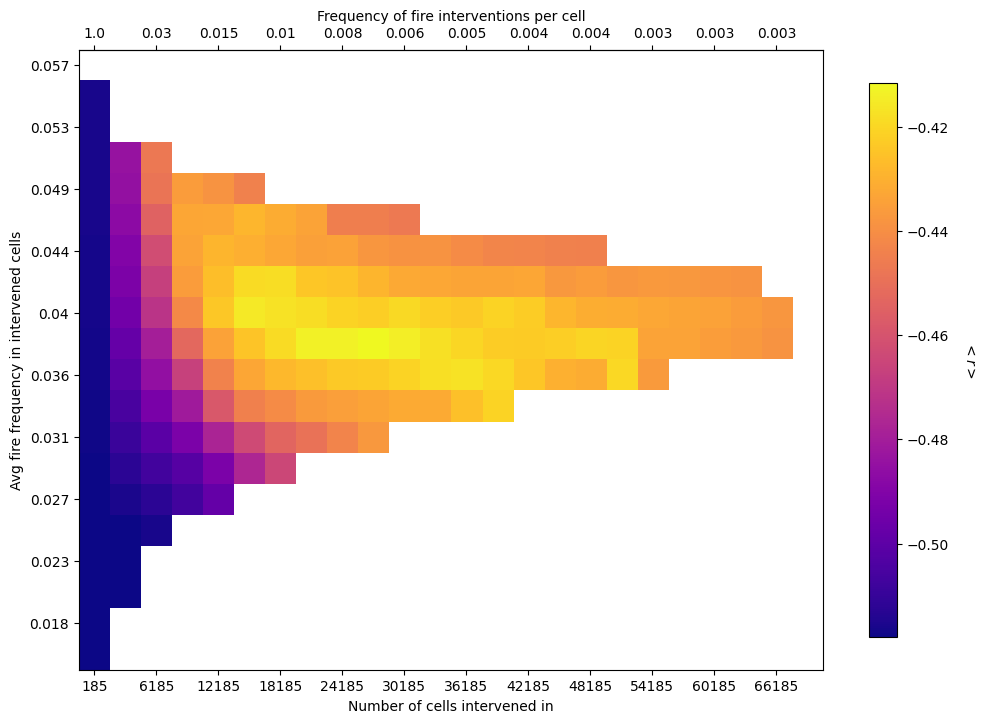

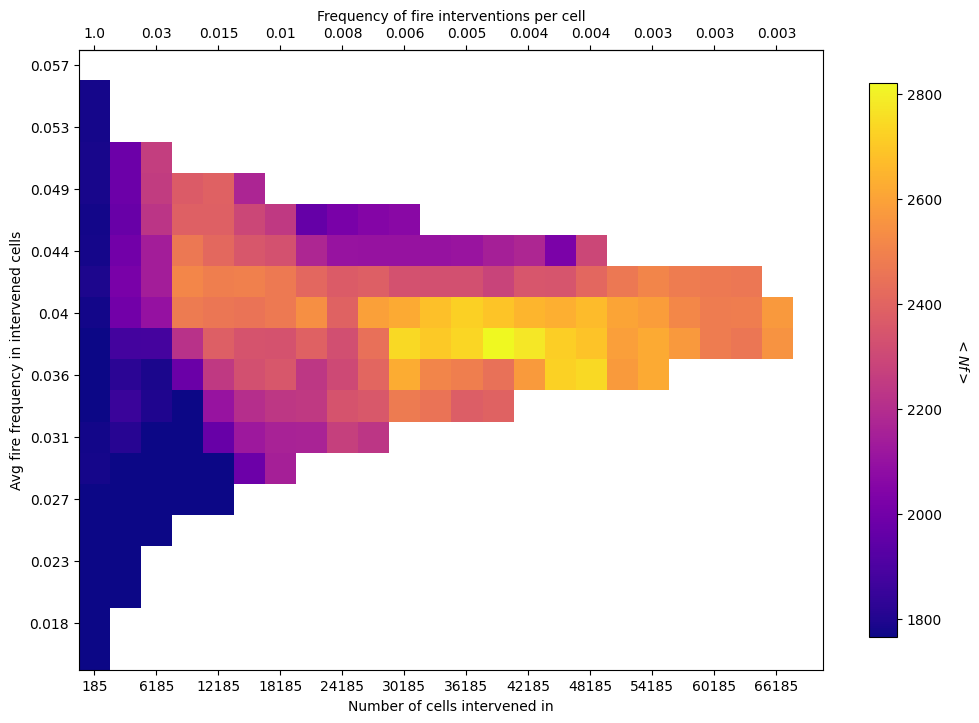

In [9]:
baseline_areas = np.array([0.05])
for baseline_area in baseline_areas:
    n_cell_baseline = round((baseline_area*1e6)/270)
    fif_baseline = 1
    constraint = n_cell_baseline * fif_baseline
    n_cell_vec = np.arange(n_cell_baseline, len(fire_freqs)-slice_left_min, 3000)
    fif_vec = np.array([constraint/n_cell for n_cell in n_cell_vec])
    for metric in ['r', 'Nf']:
        fn = "phase_mats/A_{}/phase_{}_{}.npy".format(A, metric, round(constraint))
        if not os.path.isfile(fn): continue
        phase_space = np.load(fn)
        phase_space = np.ma.masked_where(phase_space==0, phase_space)
        fn = "aggregate_data/{}_expect_nochange_A{}.json".format(metric, A)
        with open(fn, 'r') as handle:
            metric_baseline = json.load(handle)
            metric_baseline = metric_baseline["{}_expect_nochange".format(metric)]
        fig, ax = plt.subplots(figsize=(12,12))
        phase_flat = phase_space.flatten()
        cmap = copy.copy(matplotlib.cm.plasma)
        phase_max = np.max(phase_flat)
        cmap.set_bad('white')
        im = ax.imshow(phase_space, norm=matplotlib.colors.Normalize(vmin=metric_baseline, vmax=phase_max), cmap=cmap)
        cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
        cbar.ax.set_ylabel(r'$<{}>$'.format(metric), rotation=-90, fontsize=10, labelpad=20)
        freq_bin_cntrs = np.array([edge+freq_bw/2 for edge in freq_bin_edges]) #should read this in
        ytick_spacing = 2
        ytick_labels = np.flip(freq_bin_cntrs)[::ytick_spacing]
        yticks = np.arange(0,len(freq_bin_cntrs),ytick_spacing)
        ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=3));
        ax.set_ylabel('Avg fire frequency in intervened cells')
        xtick_spacing = 2
        xticks = np.arange(0,len(n_cell_vec),xtick_spacing)
        ax.set_xticks(xticks, labels=n_cell_vec[::xtick_spacing]);
        ax.set_xlabel('Number of cells intervened in')
        secax = ax.secondary_xaxis('top')
        secax.set_xticks(xticks, labels=np.round(fif_vec[::xtick_spacing], decimals=3));
        secax.set_xlabel('Frequency of fire interventions per cell')
        fig.savefig('figs/A_{}/phase_{}_{}.png'.format(A,metric,round(constraint)), bbox_inches='tight')

Text(0, 0.5, '<r>')

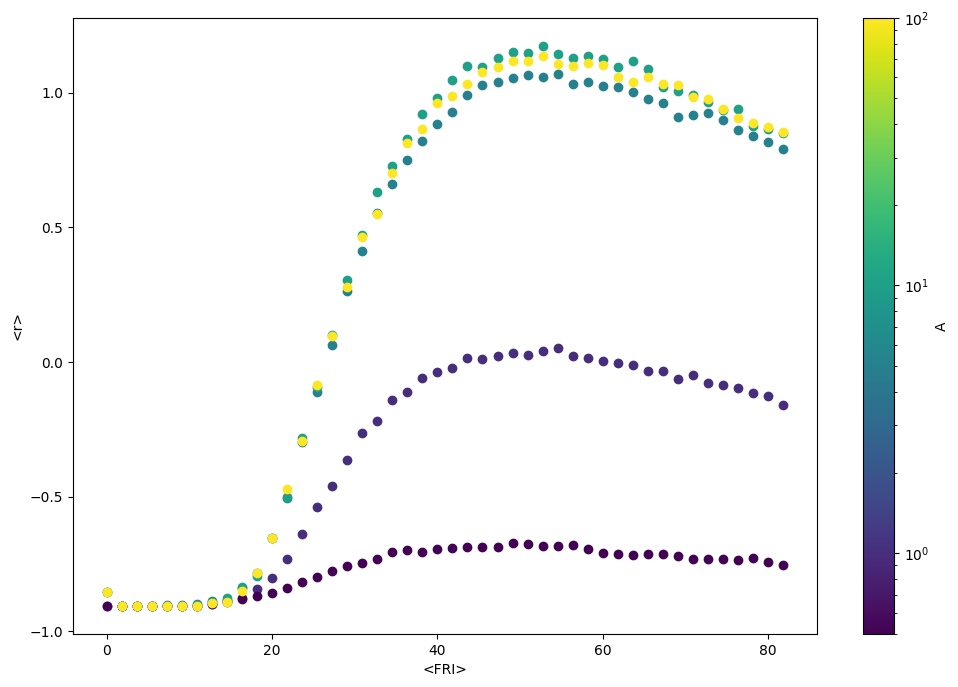

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
A_vec = np.array([1,0.5,5,10,100])
# norm = matplotlib.colors.Normalize(vmin=min(A_vec), vmax=20, clip=True)
norm = matplotlib.colors.LogNorm(vmin=min(A_vec), vmax=max(A_vec), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
for A in A_vec:
    # jobs = project.find_jobs({'doc.simulated': True, 'A': A})
    numreps = 2_000 if A == 1 else 1_000
    all_fri = np.tile(fri_vec, numreps)
    if A%1 == 0:
        fn = "aggregate_data/all_r_{}.npy".format(int(A))
    else:
        fn = "aggregate_data/all_r_{}.npy".format(A)
    with open(fn, 'rb') as handle:
        all_r = np.load(handle)
    r_bw=0.1
    r_edges = np.arange(-1, 6+r_bw, r_bw)
    fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
    fri_edges = np.concatenate(([0], np.arange(fri_step/2, fri_vec[-1]+fri_step, fri_step)))
    hist = np.histogram2d(all_fri, all_r, bins=[fri_edges, r_edges])
    dr = 0.01
    r_vals = np.arange(min(hist[2]), max(hist[2])+dr, dr)
    r_expect = 0
    r_expect_vec = []
    for fri_i in range(len(hist[0])):
        P_r_fri = scipy.stats.rv_histogram((hist[0][fri_i], hist[2]))
        r_expect_fri = np.trapz(y=P_r_fri.pdf(r_vals)*r_vals, x=r_vals)
        r_expect_vec.append(r_expect_fri)
    color = mapper.to_rgba(A)
    ax.scatter(fri_vec, r_expect_vec, color=color)
    # break
fig.colorbar(mapper, ax=ax, label='A')
ax.set_xlabel('<FRI>')
ax.set_ylabel('<r>')

In [10]:
all_r

array([-0.84503241, -1.        , -1.        , ..., -0.1202884 ,
       -0.16094144, -0.02682431])

### Robustness

In [3]:
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
bw = 0.2
bin_edges = np.arange(-1, 6+bw, bw)
metric_labels = ['bin_robustness']
metric_data = {lab: [[] for _bin in range(len(bin_edges))] for lab in metric_labels}
jobs = project.find_jobs({'doc.simulated': True})
# for job in project.find_jobs({'doc.simulated': True}):
for job in jobs:
    r_vec = np.ones(len(b_vec))*np.nan
    with job.data as data:
        for b_i, b in enumerate(b_vec):
            r_vec[b_i] = float(data['fractional_change/{}'.format(b)])
    for bin_i, left in enumerate(bin_edges):
        within = np.nonzero((r_vec >= left) & (r_vec < left+bw))[0]
        # within = np.nonzero(r_vec >= left)[0]
        bin_robustness = len(within) * fri_step
        metric_data['bin_robustness'][bin_i].append(bin_robustness)


KeyboardInterrupt



In [ ]:
metric = 'bin_robustness'
demo_samples = len(jobs)

In [ ]:
metric_max = max([max(data) for data in metric_data[metric]])

In [ ]:
r_bin_cntrs = [np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges)-1)]
r_bin_cntrs = np.array([np.round(v, decimals=1) for v in r_bin_cntrs])

In [ ]:
metric_bw = 4
# metric_min = 1 / demo_samples
metric_min = fri_step
metric_bin_edges = np.concatenate(([0,metric_min], np.arange(metric_bw, metric_max+metric_bw, metric_bw)))
metric_bin_cntrs = np.array([np.round(np.mean(metric_bin_edges[i:i+2]), decimals=2) for i in range(len(metric_bin_edges)-1)])
res_mat = np.zeros((len(metric_bin_cntrs), len(bin_edges)))

In [ ]:
for r_bin_i, r_left in enumerate(bin_edges):
    # print('response',r_left)
    for metric_bin_i, metric_left in enumerate(metric_bin_edges[:-1]):
        metric_right = metric_bin_edges[metric_bin_i+1]
        # print('metric',metric_left, metric_right)
        within = np.nonzero((metric_data[metric][r_bin_i] >= metric_left) & (metric_data[metric][r_bin_i] < metric_right))[0]
        # print(within)
        demo_count = len(within) / demo_samples
        # res_mat[len(metric_bin_edges)-1-metric_bin_i][r_bin_i] = demo_count
        res_mat[len(metric_bin_cntrs)-1-metric_bin_i][r_bin_i] = demo_count

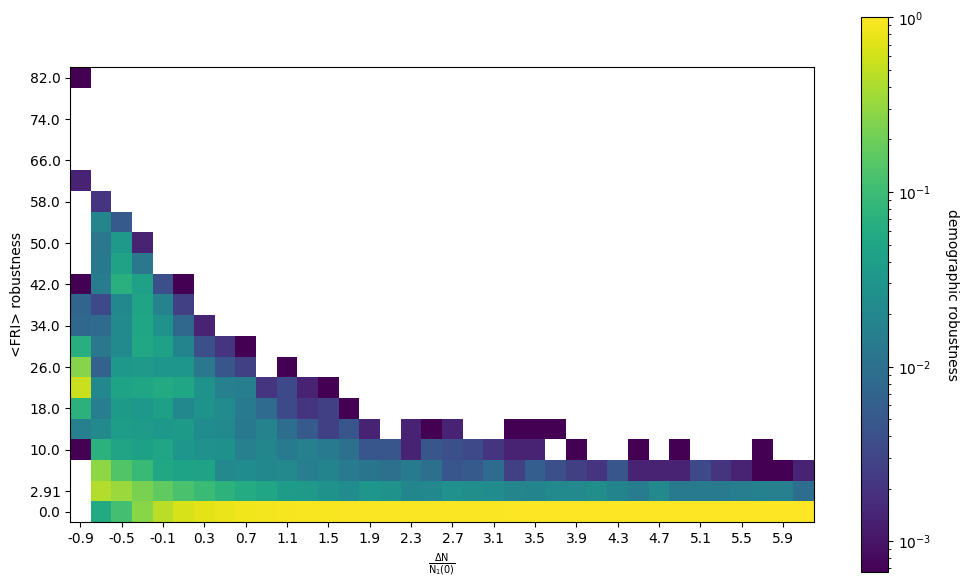

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(res_mat, norm=matplotlib.colors.LogNorm(vmax=1))
# im = ax.imshow(res_mat, norm=matplotlib.colors.Normalize(vmax=0.3))
# im = ax.imshow(res_mat[10:][:])
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ytick_spacing = 2
ytick_labels = np.flip(metric_bin_cntrs)[::ytick_spacing]
ytick_labels = np.append(ytick_labels, 0)
yticks = np.arange(0,len(metric_bin_cntrs),ytick_spacing)
yticks = np.append(yticks, len(metric_bin_cntrs)-1)
ax.set_yticks(yticks, labels=ytick_labels);
ax.set_ylabel('<FRI> robustness')
ax.set_xticks(np.arange(0,len(r_bin_cntrs),2), labels=r_bin_cntrs[::2]);
ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
# ax.set_xticks(np.arange(0,len(bin_edges),2), labels=[np.round(v, decimals=2) for v in bin_edges[::2]]);
# ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$ threshold')
# ax.set_ylim(0,10)
fig.savefig('robustness.png', bbox_inches='tight')